Calculate taus:

full signal:
1. ACF full
2. iSTTC full
   
trial average style:
1. Pearsonr trial avg
2. iSTTC trial avg
3. iSTTC trial concat

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
#os.chdir(os.path.abspath("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_tau import fit_single_exp, fit_single_exp_2d, func_single_exp, func_single_exp_monkey
from cfg_global import project_folder_path
os.chdir(current_wd)

In [2]:
dataset_folder = project_folder_path + 'results\\allen_mice\\dataset\\cut_30min\\'
fig_folder = project_folder_path + 'results\\allen_mice\\fig_draft_paper\\'

### Load data

In [3]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [4]:
units_info_df = pd.read_pickle(dataset_folder + 'sua_list_constrained_units_df.pkl')
units_info_df_subset = units_info_df[['unit_id', 'ecephys_structure_acronym']].copy()
units_info_df_subset.head(2)

,unit_id,ecephys_structure_acronym
66,950913540,VISam
67,950915005,VISam


In [5]:
acf_full_df_file = dataset_folder + 'binned\\acf\\acf_full_50ms_20lags_df.pkl'
acf_full_df = pd.read_pickle(acf_full_df_file)

acf_isttc_full_df_file = dataset_folder + 'non_binned\\acf\\acf_isttc_full_50ms_20lags_df.pkl'
acf_isttc_full_df = pd.read_pickle(acf_isttc_full_df_file)

In [23]:
with open(dataset_folder + 'binned\\acf\\pearsonr_trial_avg_50ms_20lags_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)
print(f'N signals in pearsonr_trial_avg_tau_dict {len(pearsonr_trial_avg_dict)}')

# for trial based get acf per unit (in dict acf per sampling iteration are stored)
unit_id_l = []
pearsonr_trial_avg_acf_l = []
for k,v in pearsonr_trial_avg_dict.items():
    #print(f'Unit {k}...')
    unit_id_l.append(k)
    pearsonr_trial_avg_acf_l.append(np.nanmedian(v['acf'], axis=0))

pearsonr_trial_avg_acf_df = pd.DataFrame(np.asarray(pearsonr_trial_avg_acf_l), columns=acf_cols[:-1])
pearsonr_trial_avg_acf_df.insert(0, 'unit_id', unit_id_l)
pearsonr_trial_avg_acf_df = pd.merge(pearsonr_trial_avg_acf_df, units_info_df_subset, on='unit_id', how='left')

N signals in pearsonr_trial_avg_tau_dict 2000


C:\Users\ipochino\AppData\Local\Temp\ipykernel_9600\590436517.py:11: RuntimeWarning: All-NaN slice encountered
  pearsonr_trial_avg_acf_l.append(np.nanmedian(v['acf'], axis=0))


In [ ]:
with open(dataset_folder + 'non_binned\\acf\\sttc_trial_avg_50ms_20lags_0_2000_dict.pkl', "rb") as f:
    sttc_trial_avg_dict = pickle.load(f)
print(f'N signals in sttc_trial_avg_dict {len(sttc_trial_avg_dict)}')

# for trial based get acf per unit (in dict acf per trials are stored)
unit_id_l = []
sttc_trial_avg_acf_l = []
for k,v in sttc_trial_avg_dict.items():
    #print(f'Unit {k}...')
    unit_id_l.append(k)
    sttc_trial_avg_acf_l.append(np.nanmedian(v['acf'], axis=0))

sttc_trial_avg_acf_df = pd.DataFrame(np.asarray(sttc_trial_avg_acf_l), columns=acf_cols[:-1])
sttc_trial_avg_acf_df.insert(0, 'unit_id', unit_id_l)
sttc_trial_avg_acf_df = pd.merge(sttc_trial_avg_acf_df, units_info_df_subset, on='unit_id', how='left')

In [35]:
with open(dataset_folder + 'non_binned\\acf\\sttc_trial_concat_50ms_20lags_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)
print(f'N signals in sttc_trial_avg_dict {len(sttc_trial_concat_dict)}')

# for trial based get acf per unit (in dict acf per trials are stored)
unit_id_l = []
sttc_trial_concat_acf_l = []
for k,v in sttc_trial_concat_dict.items():
    #print(f'Unit {k}...')
    unit_id_l.append(k)
    sttc_trial_concat_acf_l.append(np.nanmean(v['acf'], axis=0))

sttc_trial_concat_acf_df = pd.DataFrame(np.asarray(sttc_trial_concat_acf_l), columns=acf_cols[:-1])
sttc_trial_concat_acf_df.insert(0, 'unit_id', unit_id_l)
sttc_trial_concat_acf_df = pd.merge(sttc_trial_concat_acf_df, units_info_df_subset, on='unit_id', how='left')

N signals in sttc_trial_avg_dict 1900


In [36]:
sttc_trial_concat_acf_df.head()

,unit_id,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,acf_8,...,acf_11,acf_12,acf_13,acf_14,acf_15,acf_16,acf_17,acf_18,acf_19,ecephys_structure_acronym
0,950929874,1.0,-0.013058,0.262864,0.250131,0.213931,0.196627,0.185034,0.173367,0.142265,...,0.112051,0.106187,0.091673,0.091649,0.072500,0.087932,0.060914,0.039696,0.039228,VISp
1,950929988,1.0,0.159930,0.195643,0.206719,0.204005,0.189451,0.170639,0.149126,0.132523,...,0.111966,0.113733,0.114034,0.105602,0.115240,0.094170,0.076120,0.058071,0.062494,VISp
2,950929916,1.0,-0.100239,0.044865,0.058265,0.058209,0.060727,0.059135,0.052989,0.048687,...,0.037227,0.040536,0.030042,0.031664,0.039670,0.045647,0.044876,0.020613,0.021152,VISp
3,950929889,1.0,0.067184,0.080982,0.100397,0.080902,0.073536,0.072220,0.057411,0.053306,...,0.019439,0.033182,0.052866,0.032987,0.023127,0.016845,0.005802,0.000931,0.013487,VISp
4,950930055,1.0,0.197622,0.262444,0.251596,0.209392,0.170296,0.153447,0.137665,0.136698,...,0.085685,0.074250,0.093787,0.077403,0.066120,0.056383,0.055670,0.064704,0.011975,VISp


### Calculate taus

Get all ACF for an area and then fit exponential decay to all points (no mean area ACF)

#### Per area

In [10]:
def calc_population_tau_2d(acf_df_, acf_cols_, start_idx_, func_to_fit_):
    acf_2d = acf_df_[acf_cols_].values
    fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp_2d(acf_2d, start_idx_, func_to_fit_)
    print(f'tau {tau*50}, 95% CI {tau_ci[0]*50},{tau_ci[1]*50}')
    print(explained_var)
    return {'tau_ms':tau*50,
            'tau_lower_ms':tau_ci[0]*50, 
            'tau_upper_ms':tau_ci[1]*50, 
            'fit_r_squared': fit_r_squared, 
            'explained_var': explained_var, 
            'popt': fit_popt}

In [11]:
brain_areas = acf_full_df['ecephys_structure_acronym'].unique()
print(f'brain_areas {brain_areas}')

brain_areas ['VISam' 'LP' 'VISp' 'VISl' 'LGd' 'VISal' 'VISrl' 'VISpm']


In [12]:
acf_full_taus_dict = {}

for area in brain_areas:
    print(f'processing area {area}')
    acf_full_df_area = acf_full_df.query('ecephys_structure_acronym == @area').copy()
    print(f'N units for brain area {area}: {len(acf_full_df_area)}')
    acf_full_taus_dict[area] = calc_population_tau_2d(acf_full_df_area, acf_cols, 2, func_single_exp_monkey)

processing area VISam
N units for brain area VISam: 912
tau 336.07320279984594, 95% CI 299.7883635744778,372.3580420252141
0.1690827353887845
processing area LP
N units for brain area LP: 599
tau 257.53315535707674, 95% CI 232.53166108308338,282.53464963107007
0.21579454321067415
processing area VISp
N units for brain area VISp: 1063
tau 319.66687594979885, 95% CI 295.8336673894851,343.50008451011263
0.25481240042972364
processing area VISl
N units for brain area VISl: 727
tau 309.8334693807622, 95% CI 279.6725253656186,339.99441339590584
0.219603529405757
processing area LGd
N units for brain area LGd: 254
tau 333.6651172846553, 95% CI 263.42844626777025,403.9017883015403
0.15990826404969227
processing area VISal
N units for brain area VISal: 928
tau 308.2366813382866, 95% CI 279.836254746488,336.63710793008516
0.19632271233413445
processing area VISrl
N units for brain area VISrl: 706
tau 231.96038579674854, 95% CI 209.99032181396763,253.93044977952943
0.1802396785978574
processing a

In [13]:
acf_isttc_full_taus_dict = {}

for area in brain_areas:
    print(f'processing area {area}')
    acf_isttc_full_df_area = acf_isttc_full_df.query('ecephys_structure_acronym == @area').copy()
    print(f'N units for brain area {area}: {len(acf_isttc_full_df_area)}')
    acf_isttc_full_taus_dict[area] = calc_population_tau_2d(acf_isttc_full_df_area, acf_cols, 2, func_single_exp_monkey)

processing area VISam
N units for brain area VISam: 912
tau 399.85502484853595, 95% CI 351.1653173604175,448.5447323366545
0.17114864814808872
processing area LP
N units for brain area LP: 599
tau 251.9800373261191, 95% CI 229.890767117619,274.06930753461916
0.2477131508303504
processing area VISp
N units for brain area VISp: 1063
tau 331.80729062303647, 95% CI 306.444900795542,357.1696804505309
0.25497363660932293
processing area VISl
N units for brain area VISl: 727
tau 348.4925631627867, 95% CI 313.59680778283695,383.3883185427365
0.2380076042226681
processing area LGd
N units for brain area LGd: 254
tau 327.15158569051005, 95% CI 257.0918279682532,397.2113434127669
0.1521606469800606
processing area VISal
N units for brain area VISal: 928
tau 354.0455080223492, 95% CI 318.747327109247,389.3436889354514
0.2015809226244123
processing area VISrl
N units for brain area VISrl: 706
tau 250.81044948684777, 95% CI 224.04853974468267,277.5723592290129
0.15793493592426233
processing area VIS

In [ ]:
temp_df = pearsonr_trial_avg_acf_df.query('ecephys_structure_acronym == @brain_areas[0]').copy()
temp_df

In [ ]:
n_rows_with_nan = len(temp_df[temp_df.isna().any(axis=1)])
n_rows_with_nan

In [24]:
acf_pearsonr_trial_avg_taus_dict = {}

for area in brain_areas:
    print(f'processing area {area}')
    pearsonr_trial_avg_acf_df_area = pearsonr_trial_avg_acf_df.query('ecephys_structure_acronym == @area').copy()
    print(f'N units for brain area {area}: {len(pearsonr_trial_avg_acf_df_area)}')
    n_rows_with_nan = len(pearsonr_trial_avg_acf_df_area[pearsonr_trial_avg_acf_df_area.isna().any(axis=1)])
    pearsonr_trial_avg_acf_df_area.dropna(inplace=True)
    print(f'N n_rows_with_nan {n_rows_with_nan} for brain area {area}, removing... new N units: {len(pearsonr_trial_avg_acf_df_area)}')
    if len(pearsonr_trial_avg_acf_df_area) > 0:
        acf_pearsonr_trial_avg_taus_dict[area] = calc_population_tau_2d(pearsonr_trial_avg_acf_df_area, acf_cols[:-1], 2, func_single_exp_monkey)

processing area VISam
N units for brain area VISam: 329
N n_rows_with_nan 1 for brain area VISam, removing... new N units: 328
tau 552.3756890867453, 95% CI 377.110273184072,727.6411049894186
0.14289012733613826
processing area LP
N units for brain area LP: 239
N n_rows_with_nan 0 for brain area LP, removing... new N units: 239
tau 343.37485594009866, 95% CI 292.2723872707698,394.47732460942746
0.32515258642467937
processing area VISp
N units for brain area VISp: 430
N n_rows_with_nan 0 for brain area VISp, removing... new N units: 430
tau 441.49258150786454, 95% CI 368.45159966918555,514.5335633465436
0.24251719568906405
processing area VISl
N units for brain area VISl: 183
N n_rows_with_nan 1 for brain area VISl, removing... new N units: 182
tau 543.7501163527118, 95% CI 354.18427035045204,733.3159623549715
0.19514689334839808
processing area LGd
N units for brain area LGd: 119
N n_rows_with_nan 0 for brain area LGd, removing... new N units: 119
tau 383.77358138209706, 95% CI 233.387

In [ ]:
pearsonr_trial_avg_acf_df.head(10)

In [ ]:
sttc_trial_avg_acf_df.head(10)

In [ ]:
acf_sttc_trial_avg_taus_dict = {}

for area in brain_areas:
    print(f'processing area {area}')
    sttc_trial_avg_acf_df_area = sttc_trial_avg_acf_df.query('ecephys_structure_acronym == @area').copy()
    print(f'N units for brain area {area}: {len(sttc_trial_avg_acf_df_area)}')
    if len(sttc_trial_avg_acf_df_area) > 0:
        acf_sttc_trial_avg_taus_dict[area] = calc_population_tau_2d(sttc_trial_avg_acf_df_area, acf_cols[:-1], 2, func_single_exp_monkey)

In [37]:
acf_sttc_trial_concat_taus_dict = {}

for area in brain_areas:
    print(f'processing area {area}')
    sttc_trial_concat_acf_df_area = sttc_trial_concat_acf_df.query('ecephys_structure_acronym == @area').copy()
    print(f'N units for brain area {area}: {len(sttc_trial_concat_acf_df_area)}')
    if len(sttc_trial_concat_acf_df_area) > 0:
        acf_sttc_trial_concat_taus_dict[area] = calc_population_tau_2d(sttc_trial_concat_acf_df_area, acf_cols[:-1], 2, func_single_exp_monkey)

processing area VISam
N units for brain area VISam: 298
tau 707.7056122521692, 95% CI 408.81520929606125,1006.5960152082772
0.13964188639809016
processing area LP
N units for brain area LP: 176
tau 253.84398780454194, 95% CI 216.30830348256498,291.37967212651887
0.3083794306073466
processing area VISp
N units for brain area VISp: 424
tau 427.6337261935827, 95% CI 360.09040422342196,495.1770481637434
0.2526187188897826
processing area VISl
N units for brain area VISl: 183
tau 563.5967279010441, 95% CI 355.4146312838289,771.7788245182594
0.18651675853887062
processing area LGd
N units for brain area LGd: 119
tau 352.1773806994995, 95% CI 232.55647092241682,471.7982904765822
0.16176735221351402
processing area VISal
N units for brain area VISal: 340
tau 668.1678630395301, 95% CI 471.75621919299806,864.5795068860622
0.20940131509524573
processing area VISrl
N units for brain area VISrl: 133
tau 434.977044446284, 95% CI 293.7482255056222,576.2058633869458
0.20763780367291906
processing area

### Plots

In [16]:
save_fig=False

In [17]:
color_acf_full = '#4783B4'
color_isttc_full = '#E2552A'
color_pearson_trail_avg = 'slategray' 
color_sttc_trail_avg =  '#E97451' #'chocolate' #'#D6A27A' # 'steelblue'
color_sttc_trail_concat = '#B94E48' # '#9E5345' #'sandybrown'

In [18]:
brain_areas_axes_ticks = ['LGd', 'VISp', 'VISl', 'VISrl', 'LP', 'VISal', 'VISpm', 'VISam']
brain_areas_names = ['LGN', 'V1', 'LM', 'RL', 'LP', 'AL', 'PM', 'AM']

#### Plot ACFs - individual acfs and area fit

In [19]:
def plot_area_method(ax_, area_dict_, area_2d_, t_, color_):
    plot_label = f"ACF full: {np.round(area_dict_['tau_ms'], 1)} ms, CI [{np.round(area_dict_['tau_lower_ms'], 1)},{np.round(
        area_dict_['tau_upper_ms'],1)}] \n (n={area_2d_.shape[0]}, R-squared={np.round(area_dict_['fit_r_squared'], 3)})"

    if not np.isnan(area_dict_['tau_ms']):
        ax_.plot(t_, func_single_exp_monkey(t_, *area_dict_['popt']), color=color_)
        
    for ii in range(area_2d_.shape[0]):
        ax_.plot(t_, area_2d_[ii, 1:], lw=0.2, color=color_, alpha=0.05)
        
    ax_.set_title(plot_label, fontsize=6, y=1.05)

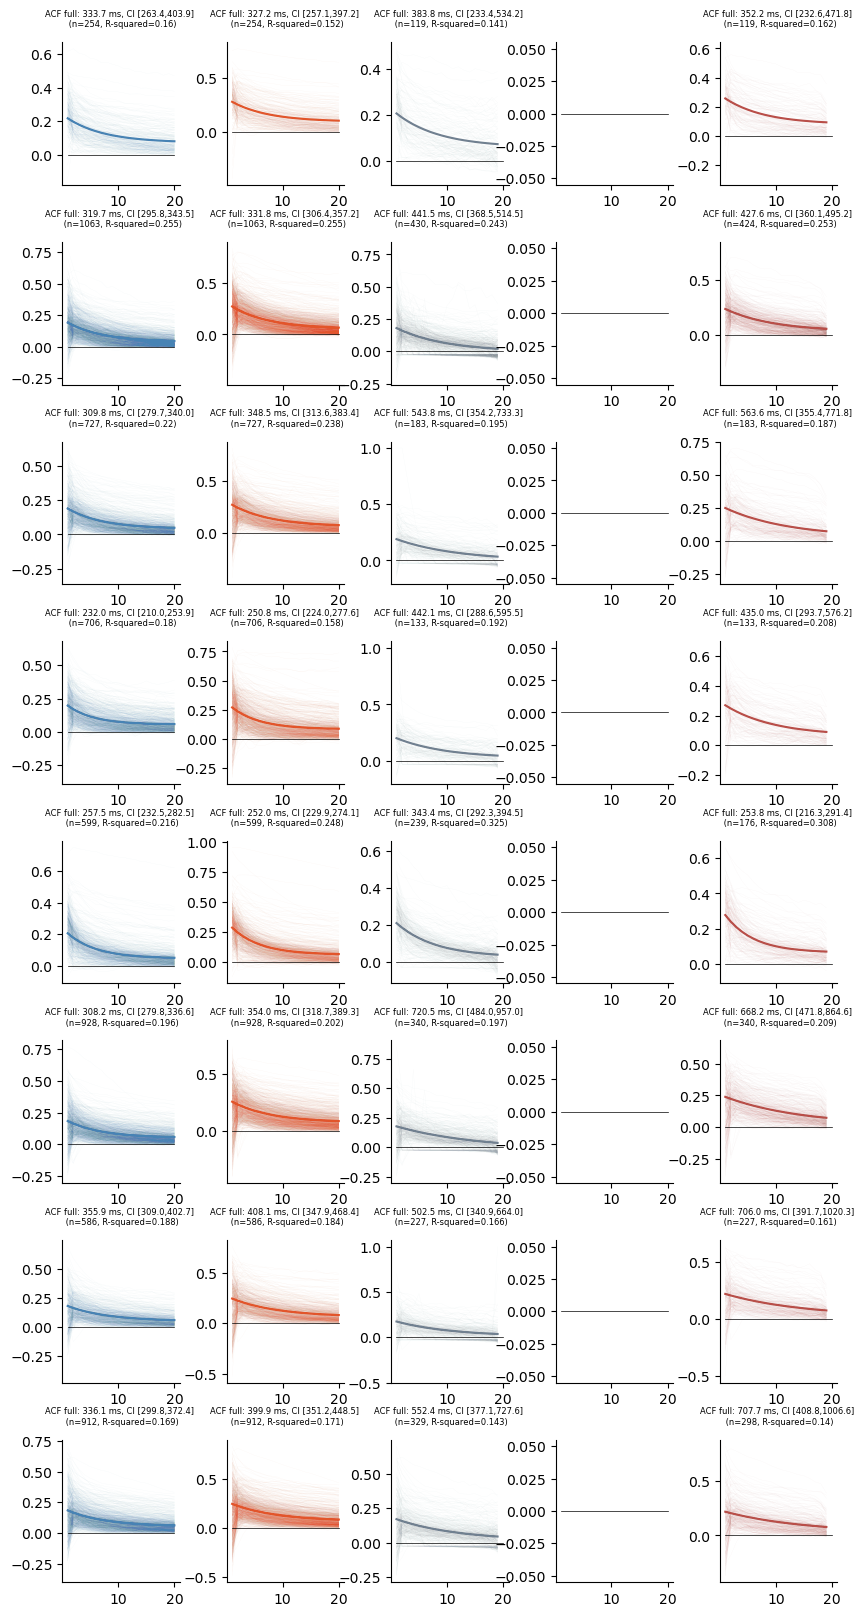

In [38]:
fig, axes = plt.subplots(8,5, figsize=(10,20), sharey=False)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

t = np.linspace(1, n_lags, n_lags).astype(int)
t_labels = np.linspace(50, 1000, n_lags).astype(int)
#print(t)
#print(t_labels)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    plot_area_method(axes[area_idx,0], acf_full_taus_dict[area], 
                     acf_full_df.query('ecephys_structure_acronym == @area')[acf_cols].values, 
                     t,
                     color_acf_full)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    plot_area_method(axes[area_idx,1], acf_isttc_full_taus_dict[area], 
                     acf_isttc_full_df.query('ecephys_structure_acronym == @area')[acf_cols].values, 
                     t,
                     color_isttc_full)
    
for area_idx, area in enumerate(brain_areas_axes_ticks):
    plot_area_method(axes[area_idx,2], acf_pearsonr_trial_avg_taus_dict[area], 
                     pearsonr_trial_avg_acf_df.query('ecephys_structure_acronym == @area')[acf_cols[:-1]].values, 
                     t[:-1],
                     color_pearson_trail_avg)

# for area_idx, area in enumerate(brain_areas_axes_ticks):
#     plot_area_method(axes[area_idx,3], acf_sttc_trial_avg_taus_dict[area], 
#                      sttc_trial_avg_acf_df.query('ecephys_structure_acronym == @area')[acf_cols[:-1]].values, 
#                      t[:-1],
#                      color_sttc_trail_avg)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    if area in acf_sttc_trial_concat_taus_dict.keys():
        plot_area_method(axes[area_idx,4], acf_sttc_trial_concat_taus_dict[area], 
                         sttc_trial_concat_acf_df.query('ecephys_structure_acronym == @area')[acf_cols[:-1]].values, 
                         t[:-1],
                         color_sttc_trail_concat)


for ax in axes.flat: 
    ax.plot(t, np.zeros(len(t)), lw=0.5, c='k')
    #ax.set_xticks(t)
    #ax.set_xticklabels(t_labels, rotation=90)
    #ax.set_xlabel('Time lag (ms)')
    #ax.set_ylabel('Autocorrelation (a.u.)')  

sns.despine()

#### Per method with confidence intervals

In [26]:
def get_plot_df(acf_dict, areas, method):
    tau = [acf_dict.get(c, {'tau_ms': np.nan})['tau_ms'] for c in areas]
    tau_lower = [acf_dict.get(c, {'tau_lower_ms': np.nan})['tau_lower_ms'] for c in areas]
    tau_upper = [acf_dict.get(c, {'tau_upper_ms': np.nan})['tau_upper_ms'] for c in areas]
    
    plot_df = pd.DataFrame({'area': areas, 
                                     'tau': tau,
                                     'tau_lower': tau_lower, 
                                     'tau_upper': tau_upper, 
                                     'method': method})
    return plot_df

In [39]:
acf_full_plot_df = get_plot_df(acf_full_taus_dict, brain_areas_axes_ticks, 'acf_full')
acf_isttc_full_plot_df = get_plot_df(acf_isttc_full_taus_dict, brain_areas_axes_ticks, 'isttc_full')
pearsonr_trial_avg_plot_df = get_plot_df(acf_pearsonr_trial_avg_taus_dict, brain_areas_axes_ticks, 'pearsonr_trial_avg')
#sttc_trial_avg_plot_df = get_plot_df(acf_sttc_trial_avg_taus_dict, brain_areas_axes_ticks, 'sttc_trial_avg')
sttc_trial_avg_plot_df = pd.DataFrame()
sttc_trial_concat_plot_df = get_plot_df(acf_sttc_trial_concat_taus_dict, brain_areas_axes_ticks, 'sttc_trial_concat')

plot_df_concat = pd.concat([acf_full_plot_df, acf_isttc_full_plot_df, pearsonr_trial_avg_plot_df, sttc_trial_avg_plot_df, sttc_trial_concat_plot_df])
plot_df_concat.reset_index(inplace=True, drop=True)
plot_df_concat.head()

,area,tau,tau_lower,tau_upper,method
0,LGd,333.665117,263.428446,403.901788,acf_full
1,VISp,319.666876,295.833667,343.500085,acf_full
2,VISl,309.833469,279.672525,339.994413,acf_full
3,VISrl,231.960386,209.990322,253.930450,acf_full
4,LP,257.533155,232.531661,282.534650,acf_full


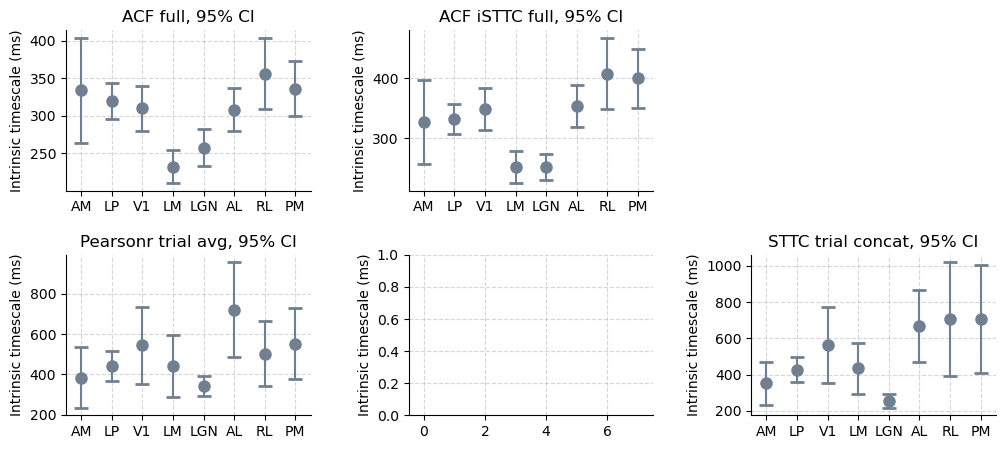

In [40]:
acf_full_error_bars = [acf_full_plot_df['tau'].values - acf_full_plot_df['tau_lower'].values, 
                       acf_full_plot_df['tau_upper'].values - acf_full_plot_df['tau'].values]
acf_isttc_full_error_bars = [acf_isttc_full_plot_df['tau'].values - acf_isttc_full_plot_df['tau_lower'].values, 
                       acf_isttc_full_plot_df['tau_upper'].values - acf_isttc_full_plot_df['tau'].values ]
pearsonr_trial_avg_full_error_bars = [pearsonr_trial_avg_plot_df['tau'].values - pearsonr_trial_avg_plot_df['tau_lower'].values, 
                       pearsonr_trial_avg_plot_df['tau_upper'].values - pearsonr_trial_avg_plot_df['tau'].values ]
# sttc_trial_avg_full_error_bars = [sttc_trial_avg_plot_df['tau'].values - sttc_trial_avg_plot_df['tau_lower'].values, 
#                        sttc_trial_avg_plot_df['tau_upper'].values - sttc_trial_avg_plot_df['tau'].values ]
sttc_trial_concat_full_error_bars = [sttc_trial_concat_plot_df['tau'].values - sttc_trial_concat_plot_df['tau_lower'].values, 
                       sttc_trial_concat_plot_df['tau_upper'].values - sttc_trial_concat_plot_df['tau'].values ]

fig, axes = plt.subplots(2, 3, figsize=(12, 5), sharey=False)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, (cond, tau, err_low, err_high) in enumerate(zip(brain_areas, acf_full_plot_df['tau'].values, 
                                                       acf_full_error_bars[0], acf_full_error_bars[1])):
    axes[0,0].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=8, color='slategray')
axes[0,0].set_xticks(brain_areas_axes_ticks)
axes[0,0].set_xticklabels(brain_areas_names)
axes[0,0].set_title('ACF full, 95% CI')

for i, (cond, tau, err_low, err_high) in enumerate(zip(brain_areas, acf_isttc_full_plot_df['tau'].values, 
                                                       acf_isttc_full_error_bars[0], acf_isttc_full_error_bars[1])):
    axes[0,1].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=8, color='slategray')
axes[0,1].set_xticks(brain_areas_axes_ticks)
axes[0,1].set_xticklabels(brain_areas_names)
axes[0,1].set_title('ACF iSTTC full, 95% CI')

axes[0,2].set_axis_off()

for i, (cond, tau, err_low, err_high) in enumerate(zip(brain_areas, pearsonr_trial_avg_plot_df['tau'].values, 
                                                       pearsonr_trial_avg_full_error_bars[0], pearsonr_trial_avg_full_error_bars[1])):
    axes[1,0].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=8, color='slategray')
axes[1,0].set_title('Pearsonr trial avg, 95% CI')
axes[1,0].set_xticks(brain_areas_axes_ticks)
axes[1,0].set_xticklabels(brain_areas_names)

# for i, (cond, tau, err_low, err_high) in enumerate(zip(brain_areas, sttc_trial_avg_plot_df['tau'].values, 
#                                                        sttc_trial_avg_full_error_bars[0], sttc_trial_avg_full_error_bars[1])):
#     axes[1,1].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=8, color='slategray')
# axes[1,1].set_title('STTC trial avg, 95% CI')
# axes[1,1].set_xticks(brain_areas_axes_ticks)
# axes[1,1].set_xticklabels(brain_areas_names)

for i, (cond, tau, err_low, err_high) in enumerate(zip(brain_areas, sttc_trial_concat_plot_df['tau'].values, 
                                                       sttc_trial_concat_full_error_bars[0], sttc_trial_concat_full_error_bars[1])):
    axes[1,2].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=8, color='slategray')
axes[1,2].set_title('STTC trial concat, 95% CI')
axes[1,2].set_xticks(brain_areas_axes_ticks)
axes[1,2].set_xticklabels(brain_areas_names)

for ax in axes.flat:
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_ylabel('Intrinsic timescale (ms)')
    # ax.set_xticklabels(['Pearson trial avg', 'STTC trial avg', 'STTC trial concat', 'Fascianelli et al.2019 \n Figure 2'], 
    #                    rotation=45, ha='right', fontsize=8)
    ax.set_xlim([-0.5, 7.5])
    

sns.despine()

if save_fig:
    fig.savefig(fig_folder + 'tau_per_area_5methods_plot_per_method.png', bbox_inches='tight', dpi=300)
    fig.savefig(fig_folder + 'tau_per_area_5methods_plot_per_method.svg', bbox_inches='tight')

#### Per area with confidence intervals

In [42]:
methods = ['acf_full', 'isttc_full', 'pearsonr_trial_avg','sttc_trial_avg', 'sttc_trial_concat']

In [43]:
def get_brain_area_df(plot_df_all_areas, area):
    area_df = plot_df_all_areas.query('area == @area').copy()
    area_df['method'] = pd.Categorical(area_df['method'], 
                                       categories=methods, ordered=True)
    area_df_ordered = area_df.sort_values(by='method')

    acf_full_error_bars = [area_df_ordered['tau'].values - area_df_ordered['tau_lower'].values, 
                       area_df_ordered['tau_upper'].values - area_df_ordered['tau'].values]

    return area_df_ordered, acf_full_error_bars

In [47]:
area_df_ordered

,area,tau,tau_lower,tau_upper,method
7,VISam,336.073203,299.788364,372.358042,acf_full
15,VISam,399.855025,351.165317,448.544732,isttc_full
23,VISam,552.375689,377.110273,727.641105,pearsonr_trial_avg
31,VISam,707.705612,408.815209,1006.596015,sttc_trial_concat


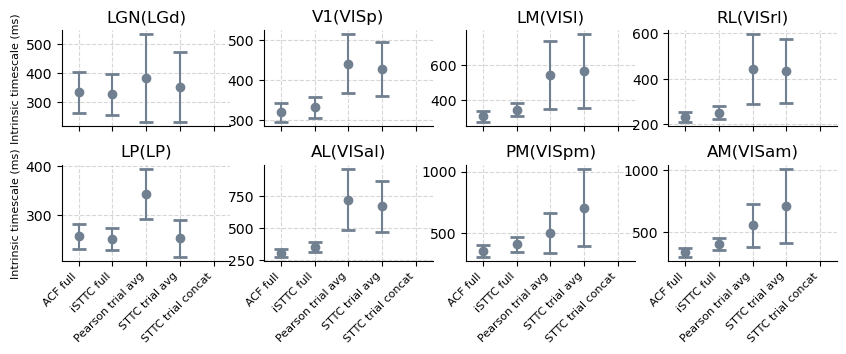

In [46]:
fig, axes = plt.subplots(2, 4, figsize=(10, 3), sharey=False)
plt.subplots_adjust(hspace=0.4, wspace=0.2)

for i in range(4):
    area_df_ordered, error_bars = get_brain_area_df(plot_df_concat, brain_areas_axes_ticks[i])
    for j, (cond, tau, err_low, err_high) in enumerate(zip(methods, area_df_ordered['tau'].values, 
                                                           error_bars[0], error_bars[1])):
        axes[0,i].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=6, color='slategray')
        axes[0,i].set_title(f'{brain_areas_names[i]}({brain_areas_axes_ticks[i]})')

for i in range(4, 8):
    area_df_ordered, error_bars = get_brain_area_df(plot_df_concat, brain_areas_axes_ticks[i])
    for jj, (cond, tau, err_low, err_high) in enumerate(zip(methods, area_df_ordered['tau'].values, 
                                                           error_bars[0], error_bars[1])):
        axes[1,i-4].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=6, color='slategray')
        axes[1,i-4].set_title(f'{brain_areas_names[i]}({brain_areas_axes_ticks[i]})')
   
axes[0,0].set_ylabel('Intrinsic timescale (ms)', fontsize=8)
axes[1,0].set_ylabel('Intrinsic timescale (ms)', fontsize=8)

for ax in axes.flat:
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xticks(['acf_full', 'isttc_full', 'pearsonr_trial_avg','sttc_trial_avg', 'sttc_trial_concat'])
    ax.set_xticklabels([])
    ax.set_xlim([-0.5, 4.5])

for ax in axes.flat[4:]:
    ax.set_xticks(['acf_full', 'isttc_full', 'pearsonr_trial_avg','sttc_trial_avg', 'sttc_trial_concat'])
    ax.set_xticklabels(['ACF full', 'iSTTC full', 'Pearson trial avg', 'STTC trial avg', 'STTC trial concat'], 
                       rotation=45, ha='right', fontsize=8)

#plt.subplots_adjust(left=.5) 
    
sns.despine()

if save_fig:
    fig.savefig(fig_folder + 'tau_per_area_5methods.png', bbox_inches='tight', dpi=300)
    fig.savefig(fig_folder + 'tau_per_area_5methods.svg', bbox_inches='tight')